# Data Exploration
In this notebook we explore the cleaned dataset. We also create some simple regression models with some basic features.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import difflib
import nltk

sns.set_theme()

In [2]:
# Import cleaned dataset
df = pd.read_csv("data/data_cleaned.csv")
df.head()

text             examen  \
0  De bewering van Kleenex is ongefundeerd aangez...  T81-210040098.txt   
1  Eén op de vijf mensen heeft last van hooikoort...  T81-210040100.txt   
2  Wij van next.checkt vinden de bewering van Kle...  T81-210040101.txt   
3  De bewering van Kleenex is ongefundeerd want h...  T81-210040102.txt   
4  Kleenex beweert dat een op de vijf mensen in N...  T81-210040103.txt   

  schooltype  id toets_id  school_id  leerling_id  T3F_54 folder  word_count  \
0        vwo  P1      T81         80           98      10    T81         145   
1        vwo  P2      T81         80          100      13    T81         149   
2        vwo  P3      T81         80          101      11    T81         142   
3        vwo  P4      T81         80          102       9    T81         143   
4        vwo  P5      T81         80          103       8    T81         110   

   nr_unreadable  
0              0  
1              0  
2              0  
3              0  
4              2

## Plot distributions

In [3]:
# How many summaries do we have per grade?
sns.displot(data=df, x = "T3F_54", bins = 15, kde=True)

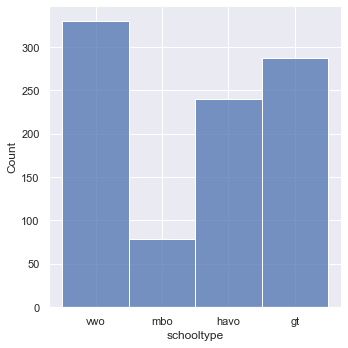

In [4]:
# How many summaries do we have per schooltype?
sns.displot(data=df, x = "schooltype")

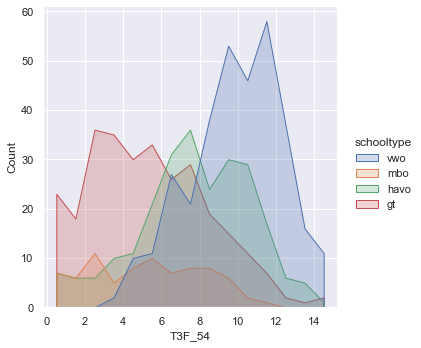

In [5]:
# Distribution of grade per schooltype
# We see that MBO and GT tend to score lower, VWO and HAVO score higher
sns.displot(data=df, x = "T3F_54", hue="schooltype", element='poly')

In [6]:
# Plot mean grade per schooltype
df.groupby(['schooltype']).mean()['T3F_54'].sort_values().plot(kind='barh')

<AxesSubplot:ylabel='schooltype'>

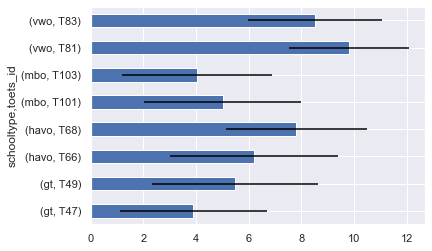

In [7]:
# For VWO, HAVO and GT there seem to be some differences between the different tests. Might be useful to include toets_id in our model.

plt.clf()
ax = plt.gca()

# Plot the mean grade per schooltype and toets_id
df.groupby(['schooltype', 'toets_id']).mean()['T3F_54'].plot(kind='barh')

# generate a dataframe with means and standard deviations
grouped_df=df.groupby(['schooltype', 'toets_id']).agg([np.mean,np.std])

# flatten column names
grouped_df.columns = [col for col in grouped_df.columns.values]
grouped_df = grouped_df.reset_index()

# Get mean and std for each row
for i,(index,row) in enumerate(grouped_df.iterrows()):
    name = row.name
    mean = row[('T3F_54', 'mean')]
    stddev = row[('T3F_54', 'std')]

    # plot the line for this group
    ax.hlines(y=i,xmin=mean-stddev,xmax=mean+stddev, color='black')

plt.show()

## Exploring the text column

In [8]:
# Add word count column
df['word_count'] = df.text.str.split().str.len()

In [9]:
# Plot distribution of word count
sns.displot(df.word_count, kde=True)

<AxesSubplot:xlabel='word_count', ylabel='T3F_54'>

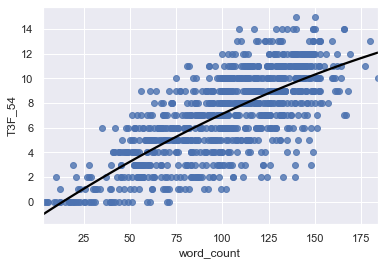

In [10]:
# Plot word count vs grade - there is a clear positive correlation. Word count could thus be a good predictor of grade.
sns.regplot(y=df.T3F_54, x=df.word_count,
                 order=2, ci=None, line_kws={"color": "black"})

<AxesSubplot:xlabel='word_count', ylabel='T3F_54'>

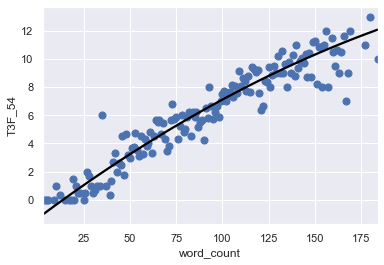

In [11]:
# This plot shows for every possible word_count the mean grade.

sns.regplot(y=df.T3F_54, x=df.word_count, x_estimator=np.mean,
                 order=2, ci=None, line_kws={"color": "black"})

## Popular words per grade

In order to look at the occurances of words we first have to preprocess the summaries. To do this, we remove stopwords and punctuation. There are two possible ways to continue: <br>

1. Tokenize: Split senteces up into words.
2. Lemmatize: Generate root form of each word. So 'speel', 'gespeeld' of 'speelden' all become 'spelen'.

For now, we have done both so we can compare the results later.

Next, we want to see if the use of words differs for summaries that scored high versus summaries that scored low.

In [12]:
from collections import Counter
import itertools
from wordcloud import WordCloud

In [13]:
# https://spacy.io/models/nl
nlp = spacy.load('nl_core_news_sm') # we moeten nog even afspreken of we het small, medium of large model willen gebruiken

def tokenize(text):
    processed_text = nlp(text.lower())
    tokenized_text = [token.text for token in processed_text if not token.is_punct]
    # tokenize text and remove punctuation
    return tokenized_text

def lemmatize(text):
    processed_text = nlp(text.lower())
    lemmatized_text = [token.lemma_ for token in processed_text if not token.is_punct]   
    # lemmatize text and remove punctuation
    return lemmatized_text

def stopword_removal(text):
    processed_text = nlp(text.lower())
    stopword_removal_text = [token.lemma_ for token in processed_text if not token.is_punct and not token.is_stop] 
    # lemmatize text, remove punctuation and stopwords
    return stopword_removal_text

In [14]:
# copy the datset and add new columns with tokens, lemmas and stopword removal
df_tokens = df.copy()
df_tokens['tokens'] = [tokenize(i) for i in df.text]
df_tokens['lemma'] = [lemmatize(i) for i in df.text]
df_tokens['stop'] = [stopword_removal(i) for i in df.text]

df_tokens.head()

text             examen  \
0  De bewering van Kleenex is ongefundeerd aangez...  T81-210040098.txt   
1  Eén op de vijf mensen heeft last van hooikoort...  T81-210040100.txt   
2  Wij van next.checkt vinden de bewering van Kle...  T81-210040101.txt   
3  De bewering van Kleenex is ongefundeerd want h...  T81-210040102.txt   
4  Kleenex beweert dat een op de vijf mensen in N...  T81-210040103.txt   

  schooltype  id toets_id  school_id  leerling_id  T3F_54 folder  word_count  \
0        vwo  P1      T81         80           98      10    T81         145   
1        vwo  P2      T81         80          100      13    T81         149   
2        vwo  P3      T81         80          101      11    T81         142   
3        vwo  P4      T81         80          102       9    T81         143   
4        vwo  P5      T81         80          103       8    T81         110   

   nr_unreadable                                             tokens  \
0              0  [de, bewering, van, kleenex, is, ongefundeerd,...   
1              0  [eén, op, de, vijf, mensen, heeft, last, van, ...   
2              0  [wij, van, next.checkt, vinden, de, bewering, ...   
3              0  [de, bewering, van, kleenex, is, ongefundeerd,...   
4              2  [kleenex, beweert, dat, een, op, de, vijf, men...   

                                               lemma  \
0  [de, bewering, van, kleenex, zijn, ongefundeer...   
1  [eén, op, de, vijf, mens, hebben, last, van, h...   
2  [wij, van, next.checkt, vinden, de, bewering, ...   
3  [de, bewering, van, kleenex, zijn, ongefundeer...   
4  [kleenex, beweren, dat, een, op, de, vijf, men...   

                                                stop  
0  [bewering, kleenex, ongefundeerd, bron, contro...  
1  [eén, vijf, mens, last, hooikoorts, aandeel, g...  
2  [next.checkt, vinden, bewering, kleenex, ongef...  
3  [bewering, kleenex, ongefundeerd, blijken, las...  
4  [kleenex, beweren, vijf, mens, nederland, last...

In [20]:
# Here you can compare the different forms of preprocessing
pd.set_option('display.max_colwidth', 100)
df_tokens.head(5)[['text', 'tokens', 'lemma', 'stop']]

text  \
0  De bewering van Kleenex is ongefundeerd aangezien haar bronnen niet controleerbaar zijn. De gebr...   
1  Eén op de vijf mensen heeft last van hooikoorts en dat aandeel groeit drastisch, aldus Kleenex. ...   
2  Wij van next.checkt vinden de bewering van Kleenex ongefundeerd Kleenex stelt dat een op de vijf...   
3  De bewering van Kleenex is ongefundeerd want het blijkt lastig om een schatting te maken van het...   
4  Kleenex beweert dat een op de vijf mensen in Nederland last van hooikoorts heeft en dat dit aant...   

                                                                                                tokens  \
0  [de, bewering, van, kleenex, is, ongefundeerd, aangezien, haar, bronnen, niet, controleerbaar, z...   
1  [eén, op, de, vijf, mensen, heeft, last, van, hooikoorts, en, dat, aandeel, groeit, drastisch, a...   
2  [wij, van, next.checkt, vinden, de, bewering, van, kleenex, ongefundeerd, kleenex, stelt, dat, e...   
3  [de, bewering, van, kleenex, is, ongefundeerd, want, het, blijkt, lastig, om, een, schatting, te...   
4  [kleenex, beweert, dat, een, op, de, vijf, mensen, in, nederland, last, van, hooikoorts, heeft, ...   

                                                                                                 lemma  \
0  [de, bewering, van, kleenex, zijn, ongefundeerd, aangezien, haar, bron, niet, controleerbaar, zi...   
1  [eén, op, de, vijf, mens, hebben, last, van, hooikoorts, en, dat, aandeel, groeien, drastisch, a...   
2  [wij, van, next.checkt, vinden, de, bewering, van, kleenex, ongefundeerd, kleenex, stellen, dat,...   
3  [de, bewering, van, kleenex, zijn, ongefundeerd, want, het, blijken, lastig, om, een, schatting,...   
4  [kleenex, beweren, dat, een, op, de, vijf, mens, in, nederland, last, van, hooikoorts, hebben, e...   

                                                                                                  stop  
0  [bewering, kleenex, ongefundeerd, bron, controleerbaar, gebruiken, site, samenwerkingsverband, w...  
1  [eén, vijf, mens, last, hooikoorts, aandeel, groeien, drastisch, kleenex, bewering, ongepundeerd...  
2  [next.checkt, vinden, bewering, kleenex, ongefundeerd, kleenex, stellen, vijf, mens, last, hooik...  
3  [bewering, kleenex, ongefundeerd, blijken, lastig, schatting, maken, aantal, mens, hooikoorts, b...  
4  [kleenex, beweren, vijf, mens, nederland, last, hooikoorts, aantal, drastisch, groeien, bewering...

In [21]:
# Make lists with words from the stopword-removal column, 
# One list for the high grades (above 9) and one list with low grades (below 5)
low_grade_stop = list(itertools.chain.from_iterable(df_tokens[df_tokens.T3F_54 <= 5].stop.tolist()))
high_grade_stop = list(itertools.chain.from_iterable(df_tokens[df_tokens.T3F_54 > 9].stop.tolist()))

In [22]:
# Function to create a world cloud
def plot_words(tokens, title = ''):
    word_counts = Counter(tokens).most_common()[:30]
    wordcloud = WordCloud(colormap='Dark2', background_color="white",).generate_from_frequencies(dict(word_counts))
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title, size = 20)
    plt.show()

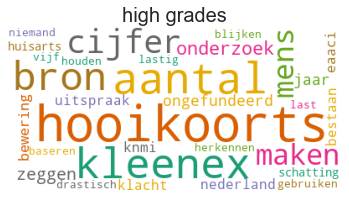

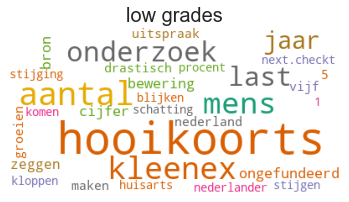

In [23]:
# We can see here that most frequent words are about the same for texts with high grades and texts with lows grades
plot_words(high_grade_stop, "high grades")
plot_words(low_grade_stop, 'low grades')

In [24]:
# Here we compare the top 30 words and only take those that are not present in the top 30 of the other group. (Thus, the distinct words)
only_low_grade = list(set(low_grade_stop[:30]) - set(high_grade_stop[:30]))
only_high_grade = list(set(high_grade_stop[:30]) - set(low_grade_stop[:30]))

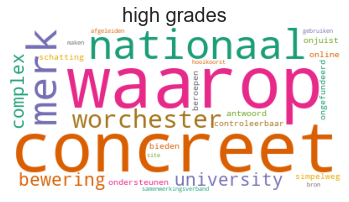

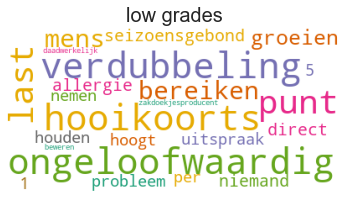

In [25]:
# Here we can which words are popular in texts with high grades and not in texts with low grades (and vice versa)
plot_words(only_high_grade, 'high grades')
plot_words(only_low_grade, 'low grades')

## Simple Regression Model
In this part of the notebook we calculate a very simple model that simply counts word occurance on both the initial as well as the cleaned dataset. The cleaned dataset scores a lot better, which is what one would expect.


In [96]:
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.decomposition
from sklearn.linear_model import LinearRegression
import sklearn.metrics as sm
from sklearn.model_selection import train_test_split

In [267]:
def calculated_and_evaluate_model(data):
    # Create train and test set
    X = list(data.text.values)
    y = list(data.T3F_54.values)

    X_train_str, X_test_str, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

    # Initialize model
    vectorizer = CountVectorizer() 

    X_train = vectorizer.fit_transform(X_train_str)
    X_test = vectorizer.fit_transform(X_test_str)

    pca = sklearn.decomposition.TruncatedSVD() # pca en svd zijn blijkbaar wat anders 
    # https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    X_train = pca.fit_transform(X_train)
    X_test = pca.fit_transform(X_test)

    model = LinearRegression().fit(X_train, y_train)

    # Print metrics
    y_test_pred = model.predict(X_test)
    print("mean_squared_error = ", round(sm.mean_squared_error(y_test, y_test_pred), 2))
    print("R2 =", round(sm.r2_score(y_test, y_test_pred), 2))
    print("explained_variance_score =", round(sm.explained_variance_score(y_test, y_test_pred), 2))

    # Plot
    sns.scatterplot(x = y_test_pred, y = y_test)
    sns.lineplot(x=range(15), y =range(15), color = 'red')
    plt.xlabel("Predicted score")
    plt.ylabel("Actual score")


In [272]:
# For the initial dataset
df_uncleaned = pd.read_csv("data/data.csv")
calculated_and_evaluate_model(df_uncleaned)

mean_squared_error =  5.85
R2 = 0.49
explained_variance_score = 0.49


In [269]:
# For the cleaned dataset
calculated_and_evaluate_model(df)

mean_squared_error =  4.33
R2 = 0.64
explained_variance_score = 0.64


Quite the improvement already!

## Comparing summaries to the original text
Here we import the original full text (the text that the studets had to summarize)

In [106]:
with open("../../Data/full_text.txt", 'r',encoding='utf-8') as file:
    text = file.read().replace('\n',' ').replace('  ', ' ')

tokenized_text = tokenize(text)
lemmatized_text = lemmatize(text)
stop_text = stopword_removal(text)

## Longest similar sequence
Between text and summaries
(from paper Automated Scoring of Summary-Writing Tasks Designed to Measure Reading Comprehension) 

If students copy bigger parts of the text, you expect that they understand the text less well (so get a lower grade)

In [111]:
# https://stackoverflow.com/questions/51053402/finding-a-sequence-in-list-using-another-list-in-python 
def list_in(a, b):
    return any(map(lambda x: b[x:x + len(a)] == a, range(len(b) - len(a) + 1)))

def similar_sequence(text,summary):
    longest = 0 
    for i in range(len(summary)):
        for n in range(len(summary)-i):
            if list_in(summary[n:n+i+1],text):
                longest = i+1
    return longest

df_tokens['token_long_similar_sequence'] = [difflib.SequenceMatcher(None,tokenized_text,i).find_longest_match(0,len(tokenized_text),0,len(i)).size 
                                     for i in df_tokens.tokens]

In [112]:
min_seq_tok = df_tokens['token_long_similar_sequence'].min()
max_seq_tok = df_tokens['token_long_similar_sequence'].max()
avg_seq_tok = df_tokens['token_long_similar_sequence'].mean()

print('minimum copied sequence tokens: ', min_seq_tok)
print('maximum copied sequence tokens: ', max_seq_tok)
print('mean longest copied sequence tokens: ', avg_seq_tok)

minimum copied sequence tokens:  1
maximum copied sequence tokens:  65
mean longest copied sequence tokens:  10.052516411378555


C:\Users\elsbo\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\elsbo\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\elsbo\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


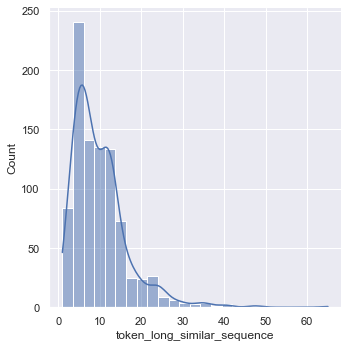

In [135]:
# plot 
# de verdeling van de longest copied sequence
sns.displot(data = df_tokens, x='token_long_similar_sequence', bins = 25, kde=True)

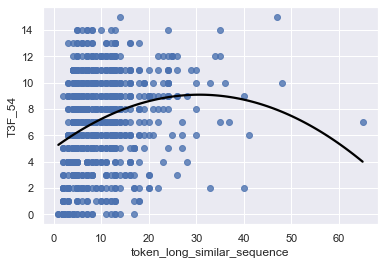

In [136]:
sns.regplot(y=df_tokens.T3F_54, x=df_tokens.token_long_similar_sequence,
            order = 2, ci=None, line_kws={"color": "black"})

We don't really see a correlation, but will the simple model improve if we put the Longest similar sequence in there?

In [276]:
def calculated_and_evaluate_model_multiple_regression(X,y):
    # Create train and test set
    X_train_str, X_test_str, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

    # Initialize model
    vectorizer = CountVectorizer() 

    X_train = vectorizer.fit_transform(X_train_str.iloc[:,0])
    X_test = vectorizer.fit_transform(X_test_str.iloc[:,0])

    pca = sklearn.decomposition.TruncatedSVD() # pca en svd zijn blijkbaar wat anders 
    # https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    X_train = pca.fit_transform(X_train)
    X_test = pca.fit_transform(X_test)

    X_train = np.column_stack([X_train, X_train_str.iloc[:,1:-1]])
    X_test = np.column_stack([X_test, X_test_str.iloc[:,1:-1]])

    model = LinearRegression().fit(X_train, y_train)

    # Print metrics
    y_test_pred = model.predict(X_test)
    print("mean_squared_error = ", round(sm.mean_squared_error(y_test, y_test_pred), 5))
    print("R2 =", round(sm.r2_score(y_test, y_test_pred), 5))
    print("explained_variance_score =", round(sm.explained_variance_score(y_test, y_test_pred), 5))

    # Plot
    sns.scatterplot(x = y_test_pred, y = y_test)
    sns.lineplot(x=range(15), y =range(15), color = 'red')
    plt.xlabel("Predicted score")
    plt.ylabel("Actual score")

In [279]:
X = df_tokens[['text']]
y = df_tokens['T3F_54']

calculated_and_evaluate_model_multiple_regression(X,y)

mean_squared_error =  4.33363
R2 = 0.64079
explained_variance_score = 0.6414


In [280]:
X = df_tokens[['text','token_long_similar_sequence']]
y = df_tokens['T3F_54']

calculated_and_evaluate_model_multiple_regression(X,y)

mean_squared_error =  4.33448
R2 = 0.64072
explained_variance_score = 0.64133


The regression doesn't really improve that much, some work is probably needed on this measure.

In [304]:
# look at the correlation 
df_tokens[['T3F_54','token_long_similar_sequence']].corr()



T3F_54  token_long_similar_sequence
T3F_54                       1.000000                     0.226617
token_long_similar_sequence  0.226617                     1.000000

In [305]:
# look at the correlation per schooltype 
df_tokens.groupby('schooltype')[['T3F_54','token_long_similar_sequence']].corr()

T3F_54  token_long_similar_sequence
schooltype                                                                   
gt         T3F_54                       1.000000                     0.335595
           token_long_similar_sequence  0.335595                     1.000000
havo       T3F_54                       1.000000                     0.235438
           token_long_similar_sequence  0.235438                     1.000000
mbo        T3F_54                       1.000000                     0.218844
           token_long_similar_sequence  0.218844                     1.000000
vwo        T3F_54                       1.000000                     0.164082
           token_long_similar_sequence  0.164082                     1.000000

## BLEU measure
https://en.wikipedia.org/wiki/BLEU 

This is also one of the measures used in the article mentioned before.

I'm using the tokenized text.

In [285]:
# first make the reference set from the 2 answers that got 100%
BLEU_reference_token_15 = df_tokens[df_tokens['T3F_54']==15].tokens.values.tolist()

In [291]:
df_tokens['BLEU_token_15'] = [nltk.translate.bleu_score.sentence_bleu(BLEU_reference_token_15, i) for i in df_tokens['tokens']]

C:\Users\elsbo\AppData\Local\Continuum\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\elsbo\AppData\Local\Continuum\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\elsbo\AppData\Local\Continuum\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contain

C:\Users\elsbo\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\elsbo\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\elsbo\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


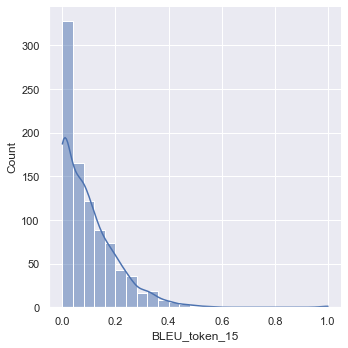

In [294]:
# plot 
# de verdeling van de BLEU score
sns.displot(data = df_tokens, x='BLEU_token_15', bins = 25, kde=True)

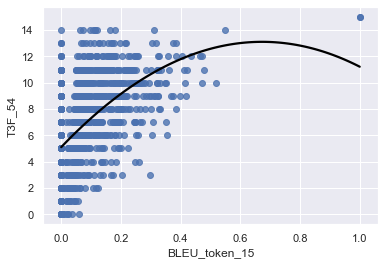

In [297]:
sns.regplot(y=df_tokens.T3F_54, x=df_tokens.BLEU_token_15,
            order = 2, ci=None, line_kws={"color": "black"})

mean_squared_error =  4.33408
R2 = 0.64075
explained_variance_score = 0.64136


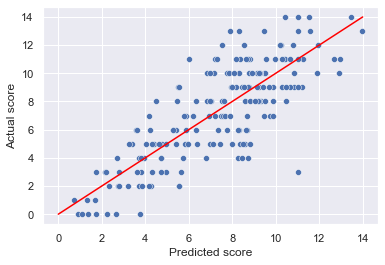

In [298]:
X = df_tokens[['text','BLEU_token_15']]
y = df_tokens['T3F_54']

calculated_and_evaluate_model_multiple_regression(X,y)

In [302]:
# Also not such a big improvement
# However, when we look at the correlations, we can see that there is indeed not such a big correlation for all school types together,
# But there is a big difference between school types.
# look at the correlation 
df_tokens[['T3F_54','BLEU_token_15']].corr()

T3F_54  BLEU_token_15
T3F_54         1.000000       0.503554
BLEU_token_15  0.503554       1.000000

In [303]:
# look at the correlation per schooltype 
df_tokens.groupby('schooltype')[['T3F_54','BLEU_token_15']].corr()

T3F_54  BLEU_token_15
schooltype                                       
gt         T3F_54         1.000000       0.619956
           BLEU_token_15  0.619956       1.000000
havo       T3F_54         1.000000       0.514828
           BLEU_token_15  0.514828       1.000000
mbo        T3F_54         1.000000       0.546791
           BLEU_token_15  0.546791       1.000000
vwo        T3F_54         1.000000       0.370228
           BLEU_token_15  0.370228       1.000000